# Gold Price Prediction
Predicts Gold Prices from [Yahoo Finance](https://query1.finance.yahoo.com/v7/finance/download/GOOG?period1=1092873600&period2=1589414400&interval=1d&events=history)

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
plt.rcParams['figure.figsize'] = (14, 10)

In [3]:
print(tf.__version__)

2.2.0


## Constants

In [4]:
DATA_URL = "https://query1.finance.yahoo.com/v7/finance/download/GOLD?period1=476323200&period2=1590019200&interval=1d&events=history"
TRAIN_DATE_BOUNDARY = '2019-01-01'
EPOCHS = 15
BATCH_SIZE = 31
STEPS = 7

## Download data
Download data from Yahoo finance and partition to test and training

In [5]:
# data = pd.read_csv(DATA_URL, index_col="Date", parse_dates=["Date"])
data = pd.read_csv(DATA_URL)

In [6]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-02-04,0.55230,0.58137,0.55230,0.55230,0.189186,50400
1,1985-02-05,0.55230,0.61044,0.55230,0.55230,0.189186,18400
2,1985-02-06,0.58137,0.65406,0.58137,0.58137,0.199143,65600
3,1985-02-07,0.58137,0.61044,0.58137,0.58137,0.199143,40000
4,1985-02-08,0.58137,0.61044,0.58137,0.58137,0.199143,25600


In [7]:
data_training = data[data['Date'] < TRAIN_DATE_BOUNDARY]
training_data = data_training.drop(['Date', 'Adj Close', 'Volume'], axis=1)
data_test = data[data['Date'] >= TRAIN_DATE_BOUNDARY]

Scale data to improve training efficiency

In [8]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)

A function for converting data into time steps dataset

In [9]:
def data_timesteps(dataset, steps = 1):
    x_data = []
    y_data = []
    for i in range(steps, dataset.shape[0]):
        x_data.append(dataset[(i - steps): i])
        y_data.append(dataset[i, 0])
    return np.array(x_data), np.array(y_data)
    

In [10]:
X_train, y_train = data_timesteps(training_data, STEPS)
X_train.shape, y_train.shape

((8540, 7, 4), (8540,))

## Model Configuration

In [11]:
# model = keras.models.Sequential()
# model.add(keras.layers.LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.LSTM(units=60, activation='relu', return_sequences=True))
# model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.LSTM(units=80, activation='relu', return_sequences=True))
# model.add(keras.layers.Dropout(0.4))
# model.add(keras.layers.LSTM(units=120, activation='relu', return_sequences=True))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(1))

# model.summary()

In [12]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

Compile and Train model

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
X_train.shape, y_train.shape

((8540, 7, 4), (8540,))

In [15]:
model_results = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    shuffle=False
)

Epoch 1/15

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

248/248 [==============================] - 3s 12ms/step - loss: 8.1684e-04 - val_loss: 0.0013
Epoch 2/15
248/248 [==============================] - 3s 10ms/step - loss: 8.2669e-04 - val_loss: 5.1268e-04
Epoch 3/15
248/248 [==============================] - 3s 10ms/step - loss: 9.9793e-04 - val_loss: 8.3293e-04
Epoch 4/15
248/248 [==============================] - 2s 10ms/step - loss: 0.0011 - val_loss: 6.5636e-04
Epoch 5/15
248/248 [==============================] - 3s 10ms/step - loss: 0.001

Plot for training and validation

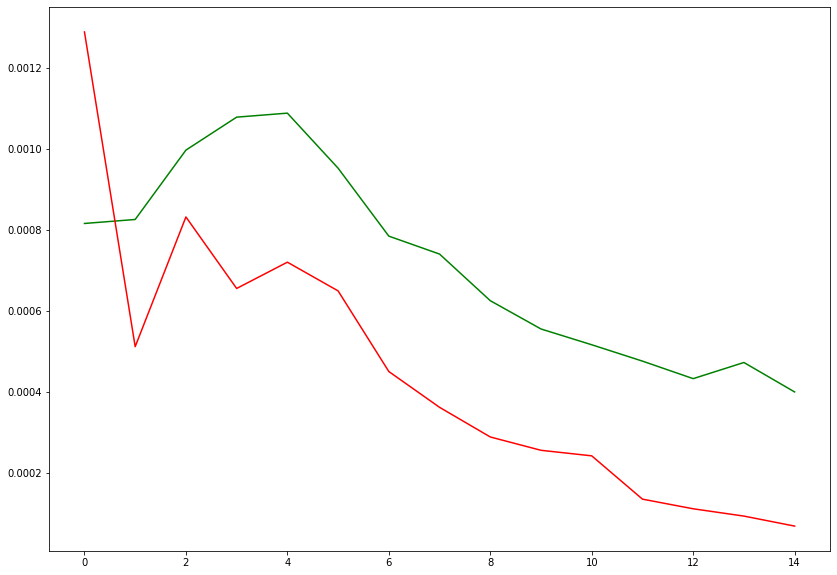

In [16]:
plt.plot(model_results.history['loss'], label='Train', color='green')
plt.plot(model_results.history['val_loss'], label='Validation', color='red')
plt.show()

## Test Model

In [17]:
past_steps_days = data_training.tail(STEPS)
df = past_steps_days.append(data_test, ignore_index=True)
df = data_test
df = df.drop(['Date', 'Adj Close', 'Volume'], axis=1)
inputs = scaler.transform(df)
    
X_test, y_test = data_timesteps(inputs, STEPS)
X_test.shape, y_test.shape

((342, 7, 4), (342,))

Predict test data

In [18]:
y_predict = model.predict(X_test)
# y_predict = np.argmax(y_predict, axis=1)
y_predict.shape

(342, 1)

Scale data back to original form

In [19]:
scale = 1/scaler.scale_[0]
y_predict = y_predict * scale
y_test = y_test * scale
# y_predict = scaler.inverse_transform(y_predict)
# y_test = scaler.inverse_transform(y_test)

## Visualize Test Prediction

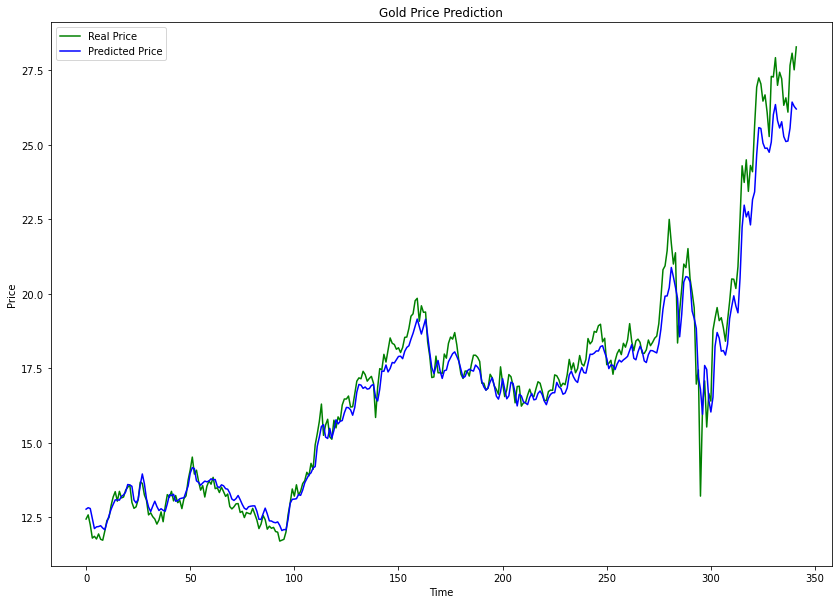

In [20]:
plt.plot(y_test, color="green", label="Real Price")
plt.plot(y_predict, color="blue", label="Predicted Price")
plt.title("Gold Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Credits
1. [KGP Talkie](https://youtu.be/arydWPLDnEc) LSTM Tutorial